In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [10]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [11]:
from tensorflow.examples.tutorials.mnist import input_data

In [12]:
mnist = input_data.read_data_sets("../03-Convolutional-Neural-Netowkrs/MNIST-data/")

W0830 02:16:10.320037 140554036832064 deprecation.py:323] From <ipython-input-12-afe24dc7e373>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0830 02:16:10.321016 140554036832064 deprecation.py:323] From /home/ryan/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0830 02:16:10.321598 140554036832064 deprecation.py:323] From /home/ryan/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed i

Extracting ../03-Convolutional-Neural-Netowkrs/MNIST-data/train-images-idx3-ubyte.gz
Extracting ../03-Convolutional-Neural-Netowkrs/MNIST-data/train-labels-idx1-ubyte.gz
Extracting ../03-Convolutional-Neural-Netowkrs/MNIST-data/t10k-images-idx3-ubyte.gz
Extracting ../03-Convolutional-Neural-Netowkrs/MNIST-data/t10k-labels-idx1-ubyte.gz


In [13]:
tf.reset_default_graph()

In [14]:
mnist.train.num_examples

55000

In [15]:
mnist.test.num_examples

10000

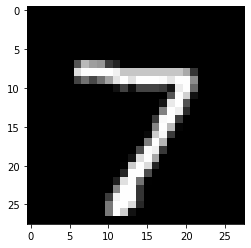

In [16]:
plt.subplots(1,1,figsize=(20,4))
plt.imshow(np.reshape(mnist.test.images[0],(28,28)),cmap='gist_gray')

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(mnist.test.images[0].reshape(-1,1))

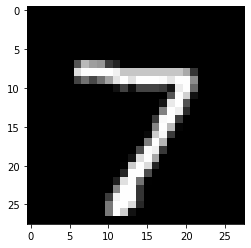

In [19]:
plt.subplots(1,1,figsize=(20,4))
plt.imshow(np.reshape(scaled_data,(28,28)),cmap='gist_gray')

In [20]:
num_inputs = 784

In [21]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(init_random_dist)

In [22]:
def init_bias(shape):
    init_bias_vals = tf.constant(.01,shape=shape)
    return tf.Variable(init_bias_vals)

In [23]:
#x -> [batch, height, width, channels]
#W -> [filter height, filter width, channel inputs, channel outputs]
def init_conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

In [24]:
def init_conv3d(x,W):
    return tf.nn.conv3d(x,W,strides=[1,1,1,1,1],padding='SAME')

In [25]:
def init_max_pooling(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [26]:
def convolutional_layer(input_x,shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(init_conv2d(input_x,W)+b)
    #return tf.nn.leaky_relu(conv2d(input_x,W)+b)

In [27]:
def normal_full_layer(input_layer,size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size,size])
    b = init_bias([size])
    return tf.matmul(input_layer,W) + b

In [28]:
x = tf.placeholder(tf.float32,shape=[None,784])

In [29]:
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [30]:
x_image = tf.reshape(x,[-1,28,28,1])

In [31]:
convo_1 = convolutional_layer(x_image,shape=[5,5,1,32])
convo_1_pooling = init_max_pooling(convo_1)

In [32]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[5,5,32,64])
convo_2_pooling = init_max_pooling(convo_2)

In [33]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])  #7 by 7 image with 64 channels

In [34]:
convo_2_flat1 = tf.reshape(convo_2_pooling,[-1,-1])

In [35]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [36]:
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,rate = 1-hold_prob)

In [37]:
y_pred = normal_full_layer(full_one_dropout,10)

In [38]:
#LOSS
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [39]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [40]:
init = tf.global_variables_initializer()

In [52]:
import time

t0 = 0
t1 = 0
steps = 100

with tf.Session() as sess:
    sess.run(init)
    
    t0 = time.time()
    
    for i in range(steps):
        batch_x, temp_batch_y = mnist.train.next_batch(50)
        
        temp = []
        for j in temp_batch_y:
            temp.append(tf.one_hot(j,10))
            
        batch_y = sess.run(temp)

        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        
        
        
        if i%100 == 0:
            #print("ON STEP: {}".format(i))
        
            
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(tf.argmax(y_true,1)))
            
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            
            #print(mnist.test.labels)
            
            temp = []
            for j in range(100):
                temp.append(tf.one_hot([mnist.test.labels[j]],10))
            
            mnist_y_labels = sess.run(tf.reshape(temp,[100,10]))
            
            #print(mnist_y_labels)
            
            t_acc = sess.run(acc,feed_dict={x:mnist.test.images,y_true:mnist_y_labels,hold_prob:1.0})
            
            print("ACCURACY: {}".format(t_acc))
        

    t1 = time.time()

total = t1-t0  
print("It took {} amount of time".format(total))


It took <module 'time' (built-in)> amount of time
169.76113939285278
